In [2]:
import os
import warnings
os.chdir('..')
warnings.filterwarnings('ignore')

# Firstly import the class of dataset
from Scripts.Data_Loader import EIRDataset

EIR_Dataset = EIRDataset('/repo/EEG-Image-Reconstruction/Generated/Data_Train/', task_type='geometric', n_jobs=10) # task type can be `geometric` or `random` or `all`

Loading .fif files: 100%|██████████| 434/434 [00:07<00:00, 59.49it/s]


In [3]:
def resample_df(EIR_Dataset: EIRDataset, freq: int):
    for i in range(len(EIR_Dataset)): 
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
        eeg_sample.resample(freq)
resample_df(EIR_Dataset, 256)

In [8]:
import numpy as np
from Scripts import Selectors_From_Dataset as sel

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from Scripts.EEGModels import EEGNet_Regression, EEGNet_Regression_One_Exit
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
#from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
kernels, chans, samples = 1, 63, 2048

# ssim computation
def compute_ssim(matrix1, matrix2):
    X = np.array(matrix1).astype(float)
    Y = np.array(matrix2).astype(float)
    
    K1 = 0.01
    K2 = 0.03
    L = 1 
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    n = 36
    
    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    cov_xy = np.sum((X - mean_x) * (Y - mean_y)) / (n - 1)
    var_x = np.var(X)
    var_y = np.var(Y)
    
    luminance = (2 * mean_x * mean_y + C1) / (mean_x ** 2 + mean_y ** 2 + C1)
    contrast = (2 * np.sqrt(var_x) * np.sqrt(var_y) + C2) / (var_x + var_y + C2)
    structure = (cov_xy + C2/2) / (np.sqrt(var_x) * np.sqrt(var_y) + C2/2)
    
    return luminance * contrast * structure

# return sorted ssim scores for all posible classes
# Assumed that predicted_matrices is array of reconstructed images and targets is dict with labels as keys and matrices as values
def predict_class(targets: dict, predicted_matrices):
    probs = []
    for i, matrix in enumerate(predicted_matrices):
        probs.append([])
        for j in targets:
            probs[i].append((j, compute_ssim(matrix, targets[j])))
        probs[i].sort(key=lambda x: x[1], reverse=True)
    return probs
        
# split into test and validation based on cooccurence of classes: there is no classes in test which was not in train
def split_preserving_train_classes(X_temp, y_temp, classes_temp, classes_train, test_size=0.5, random_state=42):

    X_temp = np.asarray(X_temp)
    y_temp = np.asarray(y_temp)
    classes_temp = np.asarray(classes_temp)
    classes_train = np.asarray(classes_train)

    train_classes = np.unique(classes_train)
    

    mask_in_train = np.isin(classes_temp, train_classes)
    X_temp_in_train = X_temp[mask_in_train]
    y_temp_in_train = y_temp[mask_in_train]
    classes_temp_in_train = classes_temp[mask_in_train]
    
    X_temp_not_in_train = X_temp[~mask_in_train]
    y_temp_not_in_train = y_temp[~mask_in_train]
    classes_temp_not_in_train = classes_temp[~mask_in_train]
    
    target_test_size = int(len(X_temp) * test_size)
    available_in_train_size = len(X_temp_in_train)
    
    if available_in_train_size >= target_test_size:
        test_size_ratio = target_test_size / available_in_train_size
        (X_validate_in_train, X_test, 
         y_validate_in_train, y_test, 
         classes_validate_in_train, classes_test) = train_test_split(
            X_temp_in_train, y_temp_in_train, classes_temp_in_train,
            test_size=test_size_ratio,
            random_state=random_state
        )
    else:
        X_test = X_temp_in_train
        y_test = y_temp_in_train
        classes_test = classes_temp_in_train
        X_validate_in_train = np.array([])
        y_validate_in_train = np.array([])
        classes_validate_in_train = np.array([])
    
    X_validate = np.concatenate([X_validate_in_train, X_temp_not_in_train]) if len(X_validate_in_train) > 0 else X_temp_not_in_train
    y_validate = np.concatenate([y_validate_in_train, y_temp_not_in_train]) if len(y_validate_in_train) > 0 else y_temp_not_in_train
    classes_validate = np.concatenate([classes_validate_in_train, classes_temp_not_in_train]) if len(classes_validate_in_train) > 0 else classes_temp_not_in_train
    
    return X_validate, X_test, y_validate, y_test, classes_validate, classes_test

# Train EEGNet model
# Possible modes: 
def in_subject_train_ver2(subject_id = None, mode = 'all', classes_mode = 'default', get_pixel = False):
    if mode in ['subj', 'subj_only_double', 'all']:
        X, y, classes = sel.get_sample(EIR_Dataset, subject_id, get_pixel=get_pixel)
        
        X_train, X_temp, y_train, y_temp, classes_train, classes_temp = train_test_split(
            X, y, classes,
            test_size=0.5,
            random_state=42,
        )
        
        if mode in ['subj', 'all']:
            X_validate, X_test, y_validate, y_test, classes_validate, classes_test = train_test_split(
                X_temp, y_temp, classes_temp,
                test_size=0.5,
                random_state=42
            )
            if get_pixel: subject_id_name = f"{subject_id}_{get_pixel[0]}_{get_pixel[1]}"
            else: subject_id_name = f"{subject_id}"
        elif mode == 'subj_only_double':
            X_validate, X_test, y_validate, y_test, classes_validate, classes_test = split_preserving_train_classes(
                X_temp, y_temp, classes_temp, classes_train,
                test_size=0.5,
                random_state=42
            )
            if get_pixel: subject_id_name = f"{subject_id}_only_known_{get_pixel[0]}_{get_pixel[1]}"
            else: subject_id_name = f"{subject_id}_only_known"
        del X, y, X_temp, y_temp

    elif mode == 'exclude':
        X_temp, y_temp, classes = sel.get_sample_exclude(EIR_Dataset, subject_id)
        X_train, X_validate, y_train, y_validate, classes_train, classes_validate = train_test_split(
            X_temp, y_temp, classes, stratify=classes,
            test_size=0.25,
            random_state=42
        )
        X_test, y_test, classes_test = sel.get_sample(EIR_Dataset, subject_id)
        if get_pixel: subject_id_name = f"{subject_id}_exclude_{get_pixel[0]}_{get_pixel[1]}"
        else: subject_id_name = f"{subject_id}_exclude"
    #return classes_train, classes_validate, classes_test

    # Reshape data to NHWC format
    X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)
    X_validate = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
    X_test = X_test.reshape(X_test.shape[0], chans, samples, kernels)

    # Create regression model
    model = EEGNet_Regression(Chans=chans, Samples=samples, 
                            dropoutRate=0.5, kernLength=32, 
                            F1=8, D=2, F2=16, 
                            dropoutType='Dropout')
    class_weights={0: 1, 1: 1}
    if get_pixel:
        class_weights = class_weight.compute_class_weight(
            'balanced',
            classes=np.unique(y_train.astype(int)),
            y=y_train
        )
        class_weights = dict(enumerate(class_weights))
        model = EEGNet_Regression_One_Exit(Chans=chans, Samples=samples, 
                            dropoutRate=0.5, kernLength=32, 
                            F1=8, D=2, F2=16, 
                            dropoutType='Dropout')

    # Compile with binary crossentropy loss
    model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

    # Training callbacks
    checkpointer = ModelCheckpoint(filepath=f"repo/EEG-Image-Research/tmp/checkpoint{subject_id_name}.h5", 
                                monitor='val_loss',
                                mode='min',
                                verbose=1,
                                save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss',
                             patience=30,
                             mode='min')

    # Train the model
    history = model.fit(X_train, y_train,
                    batch_size=1,
                    epochs=100,
                    verbose=2,
                    validation_data=(X_validate, y_validate),
                    callbacks=[checkpointer, early_stopping],
                    class_weight=class_weights)
    best_epoch = min(history.history['val_loss'])
    # Load best weights
    model.load_weights(f"repo/EEG-Image-Research/tmp/checkpoint{subject_id_name}.h5")

    # Evaluate
    test_results = model.evaluate(X_test, y_test, verbose=0)
    preds = model.predict(X_test)
    preds2 = []
    for pred in preds:
        if not get_pixel: preds2.append(pred.reshape(6, 6))
        else: preds2.append(pred)
    targs = sel.get_target_pairs(EIR_Dataset)
    test_classification = predict_class(targs, preds2)
    print(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}, ")
    return best_epoch, test_results, y_test, preds2, test_classification, model

def exploit_model(subject_id = None, mode = 'all', classes_mode = 'default', get_pixel = False):
    if mode in ['subj', 'subj_only_double', 'all']:
        X, y, classes = sel.get_sample(EIR_Dataset, subject_id, get_pixel=get_pixel)
        
        X_train, X_temp, y_train, y_temp, classes_train, classes_temp = train_test_split(
            X, y, classes,
            test_size=0.5,
            random_state=42
        )
        
        if mode in ['subj', 'all']:
            X_validate, X_test, y_validate, y_test, classes_validate, classes_test = train_test_split(
                X_temp, y_temp, classes_temp,
                test_size=0.5,
                random_state=42
            )
            if get_pixel: subject_id_name = f"{subject_id}_{get_pixel[0]}_{get_pixel[1]}"
            else: subject_id_name = f"{subject_id}"
        elif mode == 'subj_only_double':
            X_validate, X_test, y_validate, y_test, classes_validate, classes_test = split_preserving_train_classes(
                X_temp, y_temp, classes_temp, classes_train,
                test_size=0.5,
                random_state=42
            )
            if get_pixel: subject_id_name = f"{subject_id}_only_known_{get_pixel[0]}_{get_pixel[1]}"
            else: subject_id_name = f"{subject_id}_only_known"
        del X, y, X_temp, y_temp

    elif mode == 'exclude':
        X_temp, y_temp, classes = sel.get_sample_exclude(EIR_Dataset, subject_id)
        X_train, X_validate, y_train, y_validate, classes_train, classes_validate = train_test_split(
            X_temp, y_temp, classes, stratify=classes,
            test_size=0.25,
            random_state=42
        )
        X_test, y_test, classes_test = sel.get_sample(EIR_Dataset, subject_id)
        if get_pixel: subject_id_name = f"{subject_id}_exclude_{get_pixel[0]}_{get_pixel[1]}"
        else: subject_id_name = f"{subject_id}_exclude"
    #return classes_train, classes_validate, classes_test

    # Reshape data to NHWC format
    X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)
    X_validate = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
    X_test = X_test.reshape(X_test.shape[0], chans, samples, kernels)
    
    model = EEGNet_Regression(Chans=chans, Samples=samples, 
                            dropoutRate=0.5, kernLength=32, 
                            F1=8, D=2, F2=16, 
                            dropoutType='Dropout')

    if get_pixel:
        model = EEGNet_Regression_One_Exit(Chans=chans, Samples=samples, 
                            dropoutRate=0.5, kernLength=32, 
                            F1=8, D=2, F2=16, 
                            dropoutType='Dropout')
    # Compile with binary crossentropy loss
    model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['binary_accuracy'])
    #model.load_weights(f"Saved_Models/checkpoint{subject_id_name}.h5")
    model.load_weights(f"repo/EEG-Image-Research/tmp/checkpoint{subject_id_name}.h5")
    # Evaluate
    test_results = model.evaluate(X_test, y_test, verbose=0)
    preds = model.predict(X_test)
    preds2 = []
    for pred in preds:
        if not get_pixel: preds2.append(pred.reshape(6, 6))
        else: 
            preds2.append(pred)
    targs = sel.get_target_pairs(EIR_Dataset)
    if get_pixel: test_classification = None
    else: test_classification = predict_class(targs, preds2)
    print(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}, ")
    return test_results, y_test, preds2, preds, test_classification, classes_test

2025-06-26 01:23:57.652155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750901037.664628 3426576 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750901037.668108 3426576 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750901037.679123 3426576 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750901037.679131 3426576 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750901037.679133 3426576 computation_placer.cc:177] computation placer alr

In [12]:
results = []
info = {'X': [], 'Y': [], 'test_binary_accuracy': [], 'val_binary_accuracy': []}
for i in range(0, 2):
    for j in range(0, 6):
            print([i, j])
            results.append(in_subject_train_ver2(subject_id = 7, mode = 'subj', classes_mode = 'default', get_pixel = [i, j]))

[0, 0]
Epoch 1/100


2025-06-26 01:25:10.174517: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected



Epoch 1: val_loss improved from inf to 0.69921, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 3s - 238ms/step - accuracy: 0.7143 - loss: 0.7703 - val_accuracy: 0.7143 - val_loss: 0.6992
Epoch 2/100

Epoch 2: val_loss did not improve from 0.69921
14/14 - 1s - 76ms/step - accuracy: 0.7857 - loss: 0.7250 - val_accuracy: 0.5714 - val_loss: 0.7060
Epoch 3/100

Epoch 3: val_loss did not improve from 0.69921
14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.3787 - val_accuracy: 0.2857 - val_loss: 0.7139
Epoch 4/100

Epoch 4: val_loss did not improve from 0.69921
14/14 - 1s - 78ms/step - accuracy: 1.0000 - loss: 0.2299 - val_accuracy: 0.2857 - val_loss: 0.7208
Epoch 5/100

Epoch 5: val_loss did not improve from 0.69921
14/14 - 1s - 75ms/step - accuracy: 1.0000 - loss: 0.0997 - val_accuracy: 0.2857 - val_loss: 0.7235
Epoch 6/100

Epoch 6: val_loss did not improve from 0.69921
14/14 - 1s - 74ms/step - accuracy: 1.0000 - loss: 0.0458 - val_accuracy: 0.2857 - val_loss: 0.7237
Epoch 7/100

Epoch 7: val_loss did not improve from 0.69921
14/14 - 1s - 75ms/step - accuracy: 1.0000 - l

KeyboardInterrupt: 

In [ ]:
results2 = []
info = {'X': [], 'Y': [], 'test_binary_accuracy': [], 'val_binary_accuracy': []}
for i in range(0, 6):
    for j in range(0, 6):
        print([i, j])
        results2.append(exploit_model(subject_id = 7, mode = 'subj', classes_mode = 'default', get_pixel = [i, j]))

## Here starts block with Riemannian classification
Important thing: if You got error about negative leading minor - change set or just change random state

In [4]:
# Function for binary classification
def choose_classes(X: np.array, y: np.array, classes: list):
    mask = np.isin(y, classes)
    X_filtered = X[mask]
    y_filtered = y[mask]
    return X_filtered, y_filtered


(147, 63, 4096)
Classification accuracy: 0.319728 


<Figure size 640x480 with 0 Axes>

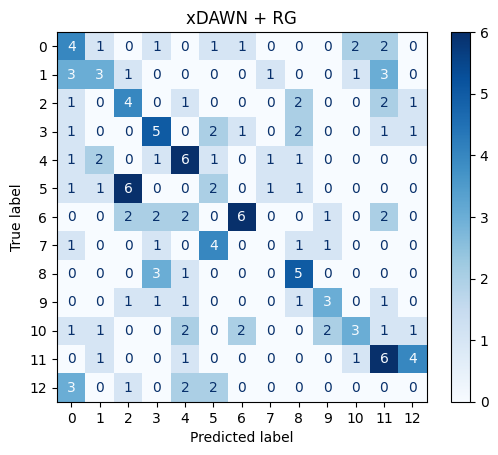

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from Scripts import Selectors_From_Dataset as sel
import mne
import scipy.signal as sg
from mne import io
from mne.datasets import sample
from Scripts.EEGModels import EEGNet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, CatBoostRegressor

n_components = 4

subjects_cluster1 = [11, 4, 8, 15]
trial_cluster1 = [2, 2, 1, 2]
subjects_cluster2 = [15, 4, 3, 10, 1, 8, 6, 1, 6]
trial_cluster2 = [1, 1, 2, 2, 2, 2, 2, 1, 1]

subjects_cluster3 = [7, 7, 9, 9, 14]
trial_cluster3 = [2, 1, 2, 1, 1]
subjects_cluster4 = [5, 5, 3, 2, 2, 10, 12, 12, 16, 16, 11, 13, 13]
trial_cluster4 = [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]

# Same as previous but trials filled for 
subjects_cluster3 = [7, 7, 9, 9, 14]
trial_cluster3 = [2, 1, 2, 1, 1]
subjects_cluster4 = [5, 5, 3, 3, 2, 2, 10, 10, 12, 12, 16, 16, 11, 11, 13, 13]
trial_cluster4 = [2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]

X, img, y = sel.get_sample_choosen_trial(EIR_Dataset, subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)
#X, img, y = get_sample_choosen_trial(subjects_cluster2 + subjects_cluster1, trial_cluster2 + trial_cluster1)
#X, img, y = get_sample()
#X, y = choose_classes(X, y, [3, 5])

# best RS = 40, ts = 0.5
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=40, 
)
X_train.shape
# set up sklearn pipeline
clf = make_pipeline(XdawnCovariances(n_components, estimator='lwf', xdawn_estimator='lwf'),
                    TangentSpace(),
                    LogisticRegression(C=3, class_weight='balanced', max_iter = 300))

'''clf = make_pipeline(XdawnCovariances(n_components, estimator='lwf'),
                    TangentSpace(),
                    CatBoostClassifier(
        task_type='CPU',
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        verbose=100,
        random_seed=42,
        eval_metric='Accuracy',
        auto_class_weights='Balanced',
        early_stopping_rounds=25
    ))'''

'''clf = make_pipeline(XdawnCovariances(n_components, estimator='lwf'),
                    TangentSpace(),
                    StandardScaler(),
                    KernelPCA(n_components=400),
                    LogisticRegression(C=1, class_weight='balanced'))'''

'''clf = make_pipeline(XdawnCovariances(n_components, estimator='lwf'),
                    TangentSpace(),
                    StandardScaler(),
                    SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', degree=4))'''

#print(cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(n_splits=4), scoring='accuracy', n_jobs=10))

preds_rg     = np.zeros(len(Y_test))

# reshape back to (trials, channels, samples)
print(X_train.shape)
clf.fit(X_train, Y_train)
preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test)
print("Classification accuracy: %f " % (acc2))

plt.figure(1)
cm_rg = confusion_matrix(Y_test, preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title(f'xDAWN + RG')

plt.show()  # Display t

In [3]:
from catboost.utils import get_gpu_device_count

print(f"Available GPU devices: {get_gpu_device_count()}")

Available GPU devices: 0


Error 100 (no CUDA-capable device is detected) ignored while obtaining device count


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import mne
import scipy.signal as sg
from mne import io
from mne.datasets import sample
from Scripts.EEGModels import EEGNet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from Scripts import Selectors_From_Dataset as sel

n_components = 8

subjects_cluster1 = [11, 4, 8, 15]
trial_cluster1 = [2, 2, 1, 2]
subjects_cluster2 = [15, 4, 3, 10, 1, 8, 6, 1, 6]
trial_cluster2 = [1, 1, 2, 2, 2, 2, 2, 1, 1]
subjects_cluster3 = [7, 7, 9, 9, 14]
trial_cluster3 = [2, 1, 2, 1, 1]
subjects_cluster4 = [5, 5, 3, 2, 2, 10, 12, 12, 16, 16, 11, 13, 13]
trial_cluster4 = [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]

accuracies = np.full((13, 13), -1.0)
f1s = np.full((13, 13), -1.0)
def train_pairwise(first, second, rs=42):
    X, img, y = sel.get_sample_choosen_trial(EIR_Dataset, subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)
    #X, img, y = get_sample_choosen_trial(subjects_cluster2 + subjects_cluster1, trial_cluster2 + trial_cluster1)
    #X, img, y = get_sample()
    X, y = choose_classes(X, y, [first, second])
    '''b = sg.firwin(100, [1, 40], pass_zero=False, window='hamming', fs=256)  

    filtered_data = np.zeros_like(X)  # Массив для отфильтрованных данных

    for i in range(X.shape[0]):  # Цикл по записям (400)
        for j in range(X.shape[1]):  # Цикл по каналам (63)
            filtered_data[i, j, :] = sg.lfilter(b, 1.0, X[i, j, :])

    X = filtered_data'''

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, y, test_size=0.5, stratify=y, random_state=rs, 
    )

    # set up sklearn pipeline
    clf = make_pipeline(XdawnCovariances(n_components, estimator='lwf'),
                        TangentSpace(),
                        LogisticRegression(C=1, class_weight='balanced'))

    '''clf = make_pipeline(XdawnCovariances(n_components, estimator='lwf'),
                        TangentSpace(),
                        StandardScaler(),
                        KernelPCA(n_components=40),
                        LogisticRegression(C=1, class_weight='balanced'))'''

    '''clf = make_pipeline(XdawnCovariances(n_components, estimator='lwf'),
                        TangentSpace(),
                        StandardScaler(),
                        SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', degree=4))'''



    preds_rg     = np.zeros(len(Y_test))

    try:
        clf.fit(X_train, Y_train)
    except Exception as e:
        if rs > 0:
            return train_pairwise(first, second, rs-1)
        else:
            return -1.0, -1.0
    preds_rg     = clf.predict(X_test)
    # Printing the results
    acc2         = np.mean(preds_rg == Y_test)
    print("Classification accuracy: %f " % (acc2))
    print("Classification f1: %f " % (f1_score(Y_test, preds_rg, pos_label=first)))
    return acc2, f1_score(Y_test, preds_rg, pos_label=first)

for i in range(12):
    for j in range(i+1, 13):
        try:
            accuracies[i][j], f1s[i][j] = train_pairwise(i, j)
            accuracies[j][i], f1s[j][i] = accuracies[i][j], f1s[i][j]
        except Exception as e:
            print(e)
            accuracies[i][j], f1s[i][j] = train_pairwise(i, j)
            accuracies[j][i], f1s[j][i] = accuracies[i][j], f1s[i][j]
            
print(accuracies)
print(f1s)

name 'choose_classes' is not defined


NameError: name 'choose_classes' is not defined

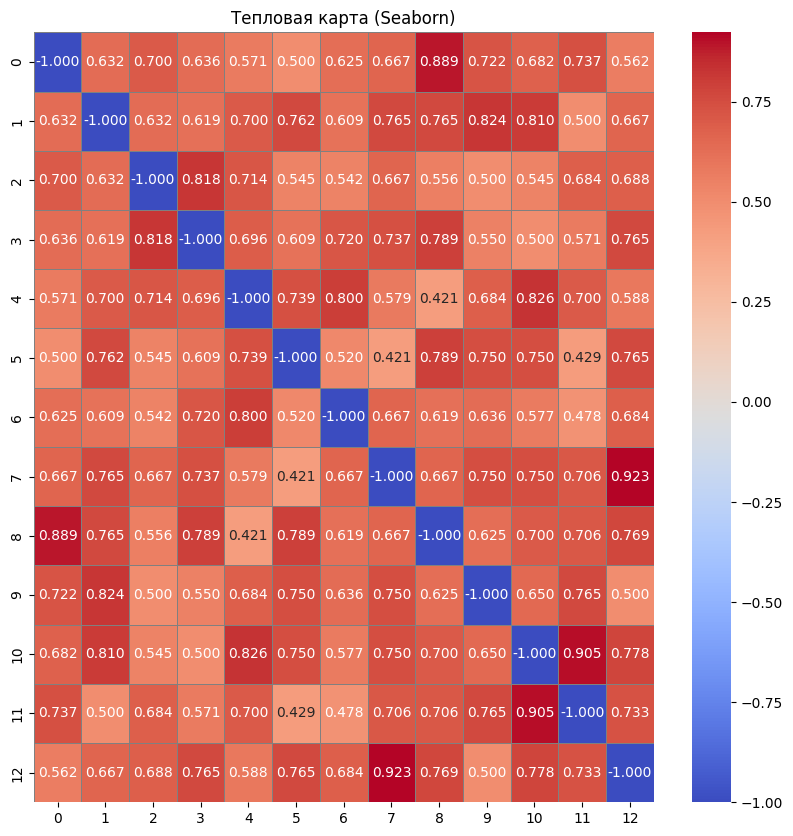

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(accuracies, annot=True, fmt=".3f", cmap='coolwarm', 
            linewidths=0.5, linecolor='gray')
plt.title('Тепловая карта (Seaborn)')
plt.show()

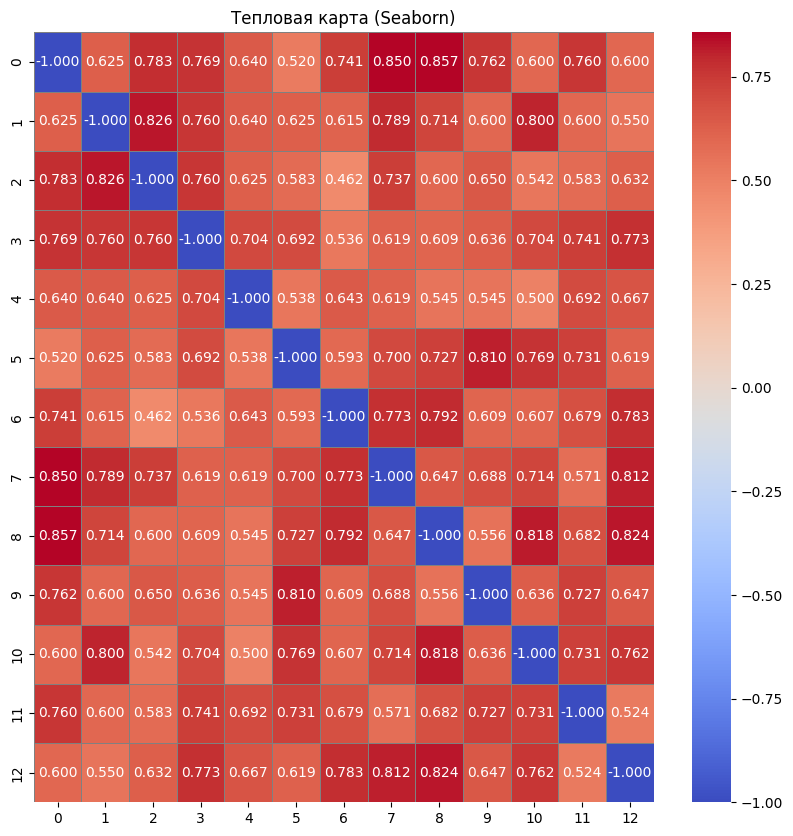

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(accuracies, annot=True, fmt=".3f", cmap='coolwarm', 
            linewidths=0.5, linecolor='gray')
plt.title('Тепловая карта (Seaborn)')
plt.show()

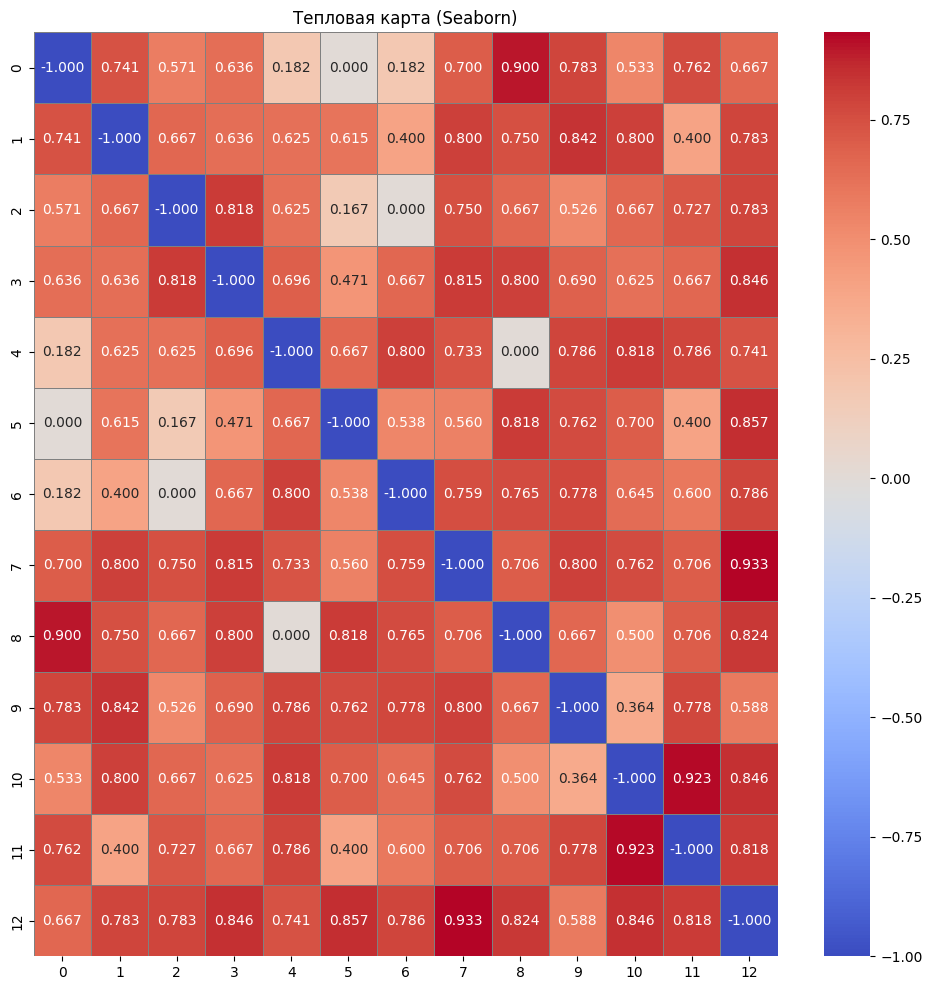

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 12))
sns.heatmap(f1s, annot=True, fmt=".3f", cmap='coolwarm', 
            linewidths=0.5, linecolor='gray')
plt.title('Тепловая карта (Seaborn)')
plt.show()

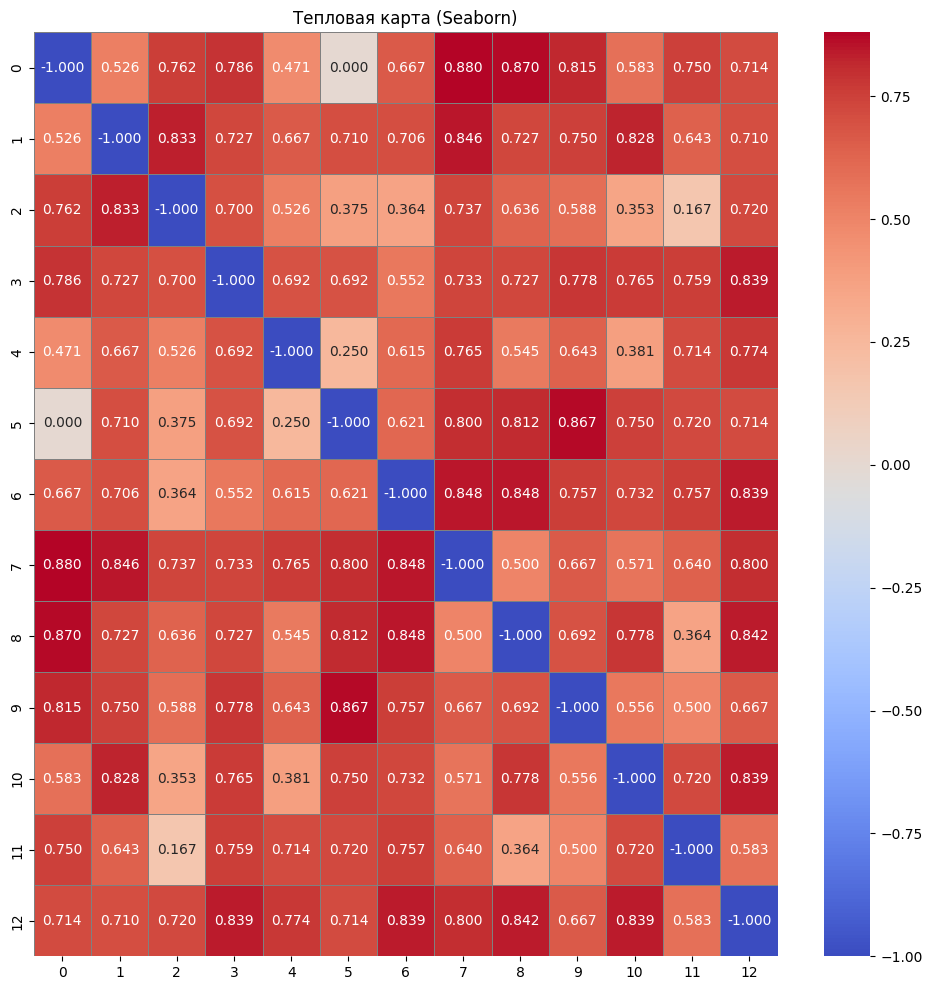

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 12))
sns.heatmap(f1s, annot=True, fmt=".3f", cmap='coolwarm', 
            linewidths=0.5, linecolor='gray')
plt.title('Тепловая карта (Seaborn)')
plt.show()

# Backlog & finetuning

In [ ]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import cross_val_score
from functools import partial
import numpy as np
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.model_selection import train_test_split
import warnings
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')

subjects_cluster1 = [11, 4, 8, 15]
trial_cluster1 = [2, 2, 1, 2]
subjects_cluster2 = [15, 4, 3, 10, 1, 8, 6, 1, 6]
trial_cluster2 = [1, 1, 2, 2, 2, 2, 2, 1, 1]
subjects_cluster3 = [7, 7, 9, 9, 14]
trial_cluster3 = [2, 1, 2, 1, 1]
subjects_cluster4 = [5, 5, 3, 2, 2, 10, 12, 12, 16, 16, 11, 13, 13]
trial_cluster4 = [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]

X, img, y = sel.get_sample_choosen_trial(subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)

# 1. Define objective function for SVC pipeline
def objective(trial, X_train, y_train, pipeline):
    params = {
        'xdawncovariances__estimator': trial.suggest_categorical('estimator', ['scm', 'lwf', 'oas']),
        
        # SVC parameters
        'svc__C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'svc__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'svc__gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'svc__class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'svc__degree': trial.suggest_int('degree', 2, 5)  # Only used for poly kernel
    }
    
    # Set parameters and handle potential conflicts
    try:
        pipeline.set_params(**params)
        scores = cross_val_score(pipeline, X_train, y_train, 
                               cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring='accuracy')
        print(scores)
        scores = [x for x in scores if x is not None and not math.isnan(x)]
        return np.mean(scores)
    except Exception as e:
        print(f"Trial failed with params {params}: {str(e)}")
        return -np.inf

# 2. Configure and run study
    

# 3. Data preparation (replace with your actual data loading)
# Assuming X and y are already loaded
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# 4. Create the pipeline with SVC
pipeline = make_pipeline(
    XdawnCovariances(nfilter=4),
    TangentSpace(),
    StandardScaler(),
    SVC()  # probability=True for predict_proba later
)
# 5. Run optimization
study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=HyperbandPruner(min_resource=1, reduction_factor=3)
    )
    
objective_func = partial(objective, X_train=X_train, y_train=y_train, pipeline=pipeline)
study.optimize(objective_func, n_trials=200, n_jobs=20)

# 6. Get best results
print(f"Best accuracy: {study.best_value:.3f}")
print("Best parameters:")
for k, v in study.best_params.items():
    print(f"{k:25s}: {v}")

# 7. Train final model with best parameters
pipeline.set_params(**study.best_params)
pipeline.fit(X_train, y_train)

# Evaluate on test set
test_accuracy = pipeline.score(X_test, y_test)
print(f"\nTest set accuracy: {test_accuracy:.3f}")

[I 2025-06-21 19:22:41,963] A new study created in memory with name: no-name-ad58471f-03bf-42bc-b829-834d20693ebf
[I 2025-06-21 19:23:09,508] Trial 7 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 343.92124357166404, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 3}. Best is trial 7 with value: 0.23650793650793647.


[0.16666667 0.31428571        nan        nan 0.22857143]


[I 2025-06-21 19:23:10,422] Trial 9 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 208.73455357847283, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 7 with value: 0.23650793650793647.


[0.16666667 0.31428571        nan        nan 0.22857143]


[I 2025-06-21 19:23:10,645] Trial 8 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 0.056972377790389085, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,685] Trial 12 finished with value: 0.23650793650793647 and parameters: {'estimator': 'lwf', 'C': 351.3210848453145, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 4}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,715] Trial 10 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 17.70888259327517, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 3}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,723] Trial 6 finished with value: 0.23650793650793647 and parameters: {'estimator': 'lwf', 'C': 67.61825334926841, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'deg

[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:10,854] Trial 18 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.34114023863346593, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 5}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,897] Trial 4 finished with value: 0.22698412698412698 and parameters: {'estimator': 'oas', 'C': 2.102832177618672, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,905] Trial 15 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.015406142045413343, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 3}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,924] Trial 16 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.17037380784519393, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'de

[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.2       ]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]


[I 2025-06-21 19:23:11,081] Trial 14 finished with value: 0.23650793650793647 and parameters: {'estimator': 'lwf', 'C': 9.866375679708858, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'degree': 4}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:11,101] Trial 17 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 0.0010877641433491713, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 5}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:11,122] Trial 5 finished with value: 0.22724867724867726 and parameters: {'estimator': 'scm', 'C': 66.99753598144237, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:11,172] Trial 2 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 0.08453409664833368, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'degree': 5}.

[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.13888889 0.37142857        nan        nan 0.17142857]
[0.16666667 0.34285714        nan        nan 0.2       ]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]


[I 2025-06-21 19:23:11,284] Trial 1 finished with value: 0.22724867724867726 and parameters: {'estimator': 'scm', 'C': 0.03350800707320067, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:11,397] Trial 3 finished with value: 0.09444444444444444 and parameters: {'estimator': 'lwf', 'C': 0.18548529764453814, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 7 with value: 0.23650793650793647.


[0.13888889 0.37142857        nan        nan 0.17142857]
[0.08333333 0.11428571        nan        nan 0.08571429]


[I 2025-06-21 19:23:13,726] Trial 20 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 5.536020523375402, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 2}. Best is trial 7 with value: 0.23650793650793647.


[0.16666667 0.31428571        nan        nan 0.22857143]


[I 2025-06-21 19:23:14,652] Trial 21 finished with value: 0.08492063492063491 and parameters: {'estimator': 'scm', 'C': 255.15306525771635, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 7 with value: 0.23650793650793647.


[0.08333333 0.08571429        nan        nan 0.08571429]


[I 2025-06-21 19:23:15,334] Trial 22 finished with value: 0.11349206349206349 and parameters: {'estimator': 'scm', 'C': 0.0024414645811072612, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 2}. Best is trial 7 with value: 0.23650793650793647.


[0.08333333 0.17142857        nan        nan 0.08571429]


[I 2025-06-21 19:23:16,406] Trial 23 finished with value: 0.2552910052910053 and parameters: {'estimator': 'lwf', 'C': 3.1150599944977393, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.2       ]


[I 2025-06-21 19:23:16,925] Trial 26 finished with value: 0.17936507936507937 and parameters: {'estimator': 'oas', 'C': 0.8928633228078222, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:16,977] Trial 24 finished with value: 0.06587301587301587 and parameters: {'estimator': 'lwf', 'C': 0.020488256870968797, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:16,978] Trial 27 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.002026025333653589, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:17,024] Trial 25 finished with value: 0.06613756613756613 and parameters: {'estimator': 'lwf', 'C': 0.15589279556174665, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', '

[0.16666667 0.22857143        nan        nan 0.14285714]
[0.08333333 0.05714286        nan        nan 0.05714286]
[0.08333333 0.22857143        nan        nan 0.08571429]
[0.05555556 0.05714286        nan        nan 0.08571429]


[I 2025-06-21 19:23:17,851] Trial 28 finished with value: 0.06587301587301587 and parameters: {'estimator': 'lwf', 'C': 6.282503767613601, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.05714286        nan        nan 0.05714286]


[I 2025-06-21 19:23:18,369] Trial 29 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 0.0011338444558150183, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:18,767] Trial 30 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 22.999515855346004, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:19,528] Trial 31 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 27.098223786494767, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:20,165] Trial 32 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 748.4303350425012, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:20,195] Trial 33 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 53.31342645643364, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]
[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:20,963] Trial 34 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 793.3462399776822, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:21,352] Trial 35 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 2.309588192584608, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:21,869] Trial 36 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 6.296727094446904, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:22,165] Trial 37 finished with value: 0.18915343915343916 and parameters: {'estimator': 'lwf', 'C': 2.5707210159407063, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.28571429        nan        nan 0.14285714]


[I 2025-06-21 19:23:22,427] Trial 38 finished with value: 0.17037037037037037 and parameters: {'estimator': 'lwf', 'C': 1.8981424096707697, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.14285714]


[I 2025-06-21 19:23:23,239] Trial 39 finished with value: 0.17037037037037037 and parameters: {'estimator': 'lwf', 'C': 1.974209773655913, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.14285714]


[I 2025-06-21 19:23:23,743] Trial 40 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 745.2896373779024, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:24,103] Trial 41 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 58.54246680449042, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:24,312] Trial 42 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 874.4026469100646, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:24,759] Trial 43 finished with value: 0.1701058201058201 and parameters: {'estimator': 'lwf', 'C': 1.0362588019233248, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.22857143        nan        nan 0.14285714]


[I 2025-06-21 19:23:25,334] Trial 44 finished with value: 0.09444444444444444 and parameters: {'estimator': 'lwf', 'C': 2.1280630957932116, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:25,350] Trial 45 finished with value: 0.08492063492063491 and parameters: {'estimator': 'lwf', 'C': 47.77274422587917, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.11428571        nan        nan 0.08571429]
[0.08333333 0.08571429        nan        nan 0.08571429]


[I 2025-06-21 19:23:26,312] Trial 46 finished with value: 0.08492063492063491 and parameters: {'estimator': 'lwf', 'C': 48.92927553144242, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.08571429        nan        nan 0.08571429]


[I 2025-06-21 19:23:26,720] Trial 47 finished with value: 0.08492063492063491 and parameters: {'estimator': 'lwf', 'C': 46.8611713159989, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.08571429        nan        nan 0.08571429]


[I 2025-06-21 19:23:27,417] Trial 48 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 47.31721583015577, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:27,809] Trial 49 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 80.0000874618524, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:28,099] Trial 50 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 713.8007804857893, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:28,446] Trial 52 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 60.02844532461022, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:28,476] Trial 51 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 78.55301554895762, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]
[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:29,099] Trial 53 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 2.0658745792342676, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:29,372] Trial 54 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 1.5802752382563081, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:29,981] Trial 55 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 1.1427088536638728, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:30,439] Trial 56 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 85.81803389253268, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:30,710] Trial 57 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 93.67189345349561, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:31,117] Trial 58 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 124.84980452856104, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:31,637] Trial 59 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 62.59110826180503, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:32,115] Trial 60 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.04509328607444269, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:32,421] Trial 61 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.05669736706844544, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:32,996] Trial 62 finished with value: 0.13253968253968254 and parameters: {'estimator': 'oas', 'C': 0.09709537076172484, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:33,300] Trial 63 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.052024055264578116, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:33,782] Trial 64 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.058402951040975745, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:33,964] Trial 65 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.06168544882105505, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]
[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:34,781] Trial 66 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.06724306666732524, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:35,074] Trial 67 finished with value: 0.13253968253968254 and parameters: {'estimator': 'oas', 'C': 0.06495328417183392, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:35,706] Trial 69 finished with value: 0.13253968253968254 and parameters: {'estimator': 'oas', 'C': 0.07408620257409386, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:35,766] Trial 68 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 121.35104806092416, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:36,113] Trial 70 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.06571788017112437, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:36,613] Trial 71 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.09121595814804236, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:36,771] Trial 72 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.03989178335605416, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]
[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:37,503] Trial 73 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.050866579765749556, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:38,093] Trial 74 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.0741967210934575, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:38,458] Trial 75 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.06261007293515192, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:39,083] Trial 76 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.06129386234378763, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:39,267] Trial 77 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.08706350142734344, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]
[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:39,726] Trial 78 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.03956333168223391, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:40,506] Trial 79 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 192.9514683563986, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:40,661] Trial 80 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 197.81753798683206, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:40,919] Trial 81 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 205.76066770583276, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:41,293] Trial 82 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 141.13381566582996, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:41,659] Trial 83 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 161.03945263185284, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:42,430] Trial 84 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 157.27611795939978, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:42,747] Trial 85 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 161.620249487267, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:43,355] Trial 86 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.4328084961166463, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:43,671] Trial 87 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 170.79057146430335, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:44,329] Trial 88 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 154.42186886127425, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:44,722] Trial 89 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 132.28411669709013, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:44,992] Trial 90 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 150.17281787723914, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:45,469] Trial 91 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 169.93169992232046, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:45,948] Trial 92 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 180.1233410096285, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:46,252] Trial 93 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 146.3068987471455, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:47,055] Trial 94 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 164.58618330235615, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:47,332] Trial 95 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 143.45282168492417, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:47,703] Trial 96 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 172.1804757016525, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:48,847] Trial 97 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 134.96602195873044, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:49,159] Trial 98 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 159.24334927878738, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:49,364] Trial 99 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 158.63528859798683, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:50,055] Trial 100 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 146.59041438910967, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:50,295] Trial 101 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 137.1537645840337, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:50,650] Trial 102 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 361.3194573981419, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:51,312] Trial 103 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 438.4283206352713, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:51,550] Trial 104 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 488.4800071221715, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:52,085] Trial 105 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 312.0818557164533, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:52,331] Trial 106 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 300.16412262011187, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:52,954] Trial 107 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 343.04240262500497, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:53,574] Trial 108 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 436.48286972256255, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:53,843] Trial 109 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 396.19026447991706, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:54,112] Trial 110 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 374.8184628873874, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:54,438] Trial 111 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 534.0808479839131, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:55,447] Trial 112 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 386.4667510479452, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:55,785] Trial 113 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 426.94931965353396, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:56,223] Trial 114 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 384.4292135284113, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:56,738] Trial 115 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 425.48308052899876, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:57,099] Trial 116 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 355.9316133292036, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:57,284] Trial 117 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 396.37020975382177, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]
[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:58,092] Trial 118 finished with value: 0.09444444444444444 and parameters: {'estimator': 'oas', 'C': 389.1302188078689, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.11428571        nan        nan 0.08571429]


[I 2025-06-21 19:23:58,686] Trial 119 finished with value: 0.09444444444444444 and parameters: {'estimator': 'oas', 'C': 362.1782729431869, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.11428571        nan        nan 0.08571429]


[I 2025-06-21 19:23:59,123] Trial 120 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 382.47776507568443, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:59,241] Trial 121 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 394.33908448778294, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:59,706] Trial 122 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 455.7782115462659, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:00,321] Trial 123 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 333.2909982860378, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:00,737] Trial 124 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 287.58076678295527, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:01,069] Trial 125 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 104.87059482908627, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:01,649] Trial 126 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 15.890786920303098, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:24:01,713] Trial 127 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 25.40842862556192, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:02,278] Trial 128 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 32.63135399017673, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:02,825] Trial 129 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 104.17439763239949, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:03,253] Trial 130 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 107.6573159895411, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:03,643] Trial 131 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 33.1178668714716, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:04,138] Trial 132 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 34.178103550264964, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:04,580] Trial 133 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 31.06876086096708, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:05,199] Trial 134 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 102.48248793650416, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:05,458] Trial 135 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 38.007793447864664, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:05,881] Trial 136 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 33.89291960943017, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:06,586] Trial 137 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 22.123291859038876, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:06,850] Trial 138 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 97.26963499826134, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:07,132] Trial 139 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 26.1779244284387, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:07,866] Trial 140 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 111.05521312415495, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:08,463] Trial 141 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 30.653962390159727, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:09,019] Trial 142 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 109.84743436105256, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:09,247] Trial 143 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 29.80642590824267, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:09,728] Trial 144 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 28.412505649264375, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:10,329] Trial 145 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 103.87593778155008, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:24:10,419] Trial 146 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 102.62977554253251, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:11,317] Trial 147 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 38.62454884713073, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:11,595] Trial 148 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 605.2930724397928, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:12,274] Trial 149 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 985.2723444768886, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:24:12,364] Trial 150 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 242.51380173213852, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:12,628] Trial 151 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 253.48922045032668, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:13,296] Trial 152 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 237.5114537963409, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:13,614] Trial 153 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 250.83492089116666, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:14,084] Trial 154 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 244.71121290739757, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:14,375] Trial 155 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 231.17404267474672, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:14,952] Trial 156 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 710.4343243050125, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:15,594] Trial 157 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 605.2169824355565, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:15,887] Trial 158 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 266.9387329500573, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:16,492] Trial 159 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 673.7995355793308, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:16,841] Trial 160 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 234.41971846776354, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:17,369] Trial 161 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 631.9182036496464, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:17,733] Trial 162 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 257.30650601784515, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:18,483] Trial 163 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 236.92846291848994, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:18,781] Trial 164 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 237.34502373216392, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:19,259] Trial 165 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 233.93902454767687, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:19,495] Trial 166 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 238.25322907897686, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:19,784] Trial 167 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 691.437172435643, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:20,408] Trial 168 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 219.55903531796633, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:21,010] Trial 169 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 254.0459562338834, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:21,596] Trial 170 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 237.90345751028562, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:21,912] Trial 171 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 63.498261949093894, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:24:21,982] Trial 172 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 69.51644935812425, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:22,797] Trial 173 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 64.06906718099516, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:23,165] Trial 174 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 63.90488385098547, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:23,452] Trial 175 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 70.88304389243403, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:23,882] Trial 176 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 73.54909090760309, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:24,269] Trial 177 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 70.27527756751867, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:24,774] Trial 178 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 68.67194587884299, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:25,220] Trial 179 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 64.66158966270781, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:25,478] Trial 180 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 64.13324457386604, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:26,137] Trial 181 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 3.820013296794624, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:26,549] Trial 182 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 68.38706746216111, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:26,822] Trial 183 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 500.953873680483, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:27,445] Trial 184 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 71.25405543911133, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:24:27,627] Trial 185 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 68.1822991499228, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:28,495] Trial 186 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 4.539517346980234, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:28,902] Trial 187 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 482.71090817690765, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:29,263] Trial 188 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 76.93222735832288, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:29,570] Trial 189 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 65.06434502759987, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:30,274] Trial 190 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 65.89777335954953, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:30,539] Trial 191 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 499.85050115141377, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:30,898] Trial 192 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 522.126141566764, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:31,391] Trial 193 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 520.1073070956058, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:31,815] Trial 194 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 3.3002033606845007, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:32,289] Trial 195 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 504.86715714885736, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:32,672] Trial 196 finished with value: 0.2552910052910053 and parameters: {'estimator': 'lwf', 'C': 496.22463568824736, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.2       ]


[I 2025-06-21 19:24:33,527] Trial 197 finished with value: 0.2552910052910053 and parameters: {'estimator': 'lwf', 'C': 133.35362579366054, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.2       ]


[I 2025-06-21 19:24:33,739] Trial 198 finished with value: 0.2552910052910053 and parameters: {'estimator': 'lwf', 'C': 510.9133893219962, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.2       ]


[I 2025-06-21 19:24:34,463] Trial 199 finished with value: 0.2552910052910053 and parameters: {'estimator': 'lwf', 'C': 503.48425057151456, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.2       ]
Best accuracy: 0.255
Best parameters:
estimator                : lwf
C                        : 3.1150599944977393
kernel                   : rbf
gamma                    : auto
class_weight             : None
degree                   : 5


ValueError: Invalid parameter 'estimator' for estimator Pipeline(steps=[('xdawncovariances', XdawnCovariances(estimator='lwf')),
                ('tangentspace', TangentSpace()),
                ('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=503.48425057151456, class_weight='balanced', degree=4,
                     gamma='auto'))]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

In [ ]:
print(study.best_params)

{'estimator': 'lwf', 'C': 3.1150599944977393, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}


Classification accuracy: 0.186441 


<Figure size 640x480 with 0 Axes>

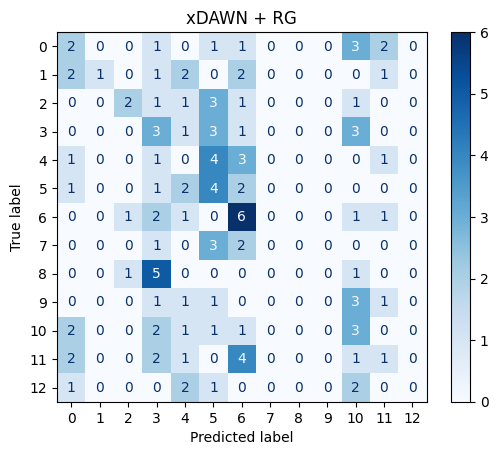

In [ ]:
clf = make_pipeline(
    XdawnCovariances(nfilter=4, estimator = 'oas'),
    TangentSpace(),
    StandardScaler(),
    SVC(C = 3.3002033606845007, kernel = 'rbf', gamma = 'auto', class_weight = 'balanced', degree = 4)  # probability=True for predict_proba later
)
#pipeline.set_params(**study.best_params)
clf.fit(X_train, y_train)

preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == y_test)
print("Classification accuracy: %f " % (acc2))
plt.figure(1)
cm_rg = confusion_matrix(y_test, preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title('xDAWN + RG')

plt.show()  # Display t

In [ ]:
get_target_pairs()[12]

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [ ]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import cross_val_score
from functools import partial
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import mne
from mne import io
from mne.datasets import sample
from Scripts.EEGModels import EEGNet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings
import math
warnings.filterwarnings('ignore')

# 1. Define objective function
def objective(trial, X_train, y_train, pipeline):
    params = {
        # XdawnCovariances
        'xdawncovariances__nfilter': trial.suggest_int('nfilter', 2, 8),
        'xdawncovariances__estimator': trial.suggest_categorical('cov_est', ['scm', 'lwf', 'oas']),
        
        # TangentSpace
        'tangentspace__metric': trial.suggest_categorical('metric', ['riemann', 'logeuclid']),
        
        # LogisticRegression
        'logisticregression__C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'logisticregression__solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga']),
        'logisticregression__penalty': trial.suggest_categorical('penalty', ['l2', 'l1']),
        'logisticregression__class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    
    # Handle incompatible parameter combinations
    if params['logisticregression__penalty'] == 'l1':
        params['logisticregression__solver'] = 'liblinear'
    
    try:
        pipeline.set_params(**params)
        scores = cross_val_score(pipeline, X_train, y_train, 
                               cv=5, n_jobs=1, scoring='accuracy')
        print(scores)
        scores = [x for x in scores if x is not None and not (isinstance(x, float) and math.isnan(x))]
        print(scores)
        return np.mean(scores)
    except Exception as e:
        # Return negative infinity for failed trials
        print(f"Trial failed with params {params}: {str(e)}")
        return -np.inf

# 2. Configure and run study
def optimize_with_optuna(X_train, y_train, pipeline, n_trials=30):
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=HyperbandPruner(min_resource=1, reduction_factor=3)
    )
    
    objective_func = partial(objective, X_train=X_train, y_train=y_train, pipeline=pipeline)
    study.optimize(objective_func, n_trials=n_trials, n_jobs=20)
    
    return study

n_components = 4  # pick some components
chans = 63
samples = 16001

# Data loading
subjects_cluster1 = [11, 4, 8, 15]
trial_cluster1 = [2, 2, 1, 2]
subjects_cluster2 = [15, 4, 3, 10, 1, 8, 6, 1, 6]
trial_cluster2 = [1, 1, 2, 2, 2, 2, 2, 1, 1]
subjects_cluster3 = [7, 7, 9, 9, 14]
trial_cluster3 = [2, 1, 2, 1, 1]
subjects_cluster4 = [5, 5, 3, 2, 2, 10, 12, 12, 16, 16, 11, 13, 13]
trial_cluster4 = [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]

X, img, y = get_sample_choosen_trial(subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)
X, img, y = get_sample()
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)

# 3. Usage with your EEG pipeline
pipeline = make_pipeline(
    XdawnCovariances(nfilter=4),
    TangentSpace(),
    LogisticRegression(max_iter=250)
)

study = optimize_with_optuna(X_train, Y_train, pipeline, n_trials=150)

# 4. Get best results
print(f"Best accuracy: {study.best_value:.3f}")
print("Best params:")
for k, v in study.best_params.items():
    print(f"{k:20s}: {v}")

# 5. Train final model with best params
pipeline.set_params(**study.best_params)
pipeline.fit(X_train, Y_train)

[I 2025-06-21 18:32:31,437] A new study created in memory with name: no-name-0bd95a25-56ec-48e5-ac37-8b67a70a670d
[I 2025-06-21 18:34:56,624] Trial 14 finished with value: 0.16094080338266387 and parameters: {'nfilter': 3, 'cov_est': 'oas', 'metric': 'riemann', 'C': 88.48816548357466, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:34:58,672] Trial 10 finished with value: 0.14931289640591966 and parameters: {'nfilter': 5, 'cov_est': 'scm', 'metric': 'riemann', 'C': 380.41213522736297, 'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.15909091        nan        nan 0.13953488]
[np.float64(0.1590909090909091), np.float64(0.13953488372093023)]


[I 2025-06-21 18:35:04,377] Trial 4 finished with value: 0.14957716701902748 and parameters: {'nfilter': 5, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.1300388505728845, 'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:35:05,009] Trial 17 finished with value: 0.14957716701902748 and parameters: {'nfilter': 5, 'cov_est': 'oas', 'metric': 'logeuclid', 'C': 0.0028253582589121543, 'solver': 'lbfgs', 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:35:11,278] Trial 15 finished with value: 0.16094080338266387 and parameters: {'nfilter': 6, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.003982444740701444, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:35:13,096] Trial 0 finished with value: 0.14957716701902748 and parameters: {'nfilter': 4, 'cov_est': 'scm', 'metric': 'logeuclid', 'C': 0.01554388698932314, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:35:22,620] Trial 9 finished with value: 0.14957716701902748 and parameters: {'nfilter': 8, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.020801304045116036, 'solver': 'saga', 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:35:33,452] Trial 11 finished with value: 0.14931289640591966 and parameters: {'nfilter': 6, 'cov_est': 'oas', 'metric': 'logeuclid', 'C': 0.013787338801299872, 'solver': 'saga', 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.15909091        nan        nan 0.13953488]
[np.float64(0.1590909090909091), np.float64(0.13953488372093023)]


[I 2025-06-21 18:36:04,134] Trial 16 finished with value: 0.14957716701902748 and parameters: {'nfilter': 5, 'cov_est': 'scm', 'metric': 'logeuclid', 'C': 0.0022191236828926235, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:04,559] Trial 19 finished with value: 0.14957716701902748 and parameters: {'nfilter': 5, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.0022936793811787737, 'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:05,293] Trial 8 finished with value: 0.16094080338266387 and parameters: {'nfilter': 8, 'cov_est': 'oas', 'metric': 'logeuclid', 'C': 0.26012243228172616, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:05,503] Trial 12 finished with value: 0.17230443974630022 and parameters: {'nfilter': 7, 'cov_est': 'scm', 'metric': 'logeuclid', 'C': 16.68011047827428, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.18181818        nan        nan 0.1627907 ]
[np.float64(0.18181818181818182), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:05,933] Trial 2 finished with value: 0.14957716701902748 and parameters: {'nfilter': 3, 'cov_est': 'scm', 'metric': 'riemann', 'C': 0.0012992914063234668, 'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': None}. Best is trial 12 with value: 0.17230443974630022.
[I 2025-06-21 18:36:06,006] Trial 13 finished with value: 0.16094080338266387 and parameters: {'nfilter': 8, 'cov_est': 'scm', 'metric': 'logeuclid', 'C': 0.0010102297058103657, 'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': None}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]
[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:06,925] Trial 5 finished with value: 0.17230443974630022 and parameters: {'nfilter': 3, 'cov_est': 'scm', 'metric': 'logeuclid', 'C': 135.67537270500972, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.17230443974630022.
[I 2025-06-21 18:36:07,119] Trial 6 finished with value: 0.14931289640591966 and parameters: {'nfilter': 2, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.13637203697305847, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.18181818        nan        nan 0.1627907 ]
[np.float64(0.18181818181818182), np.float64(0.16279069767441862)]
[       nan 0.15909091        nan        nan 0.13953488]
[np.float64(0.1590909090909091), np.float64(0.13953488372093023)]


[I 2025-06-21 18:36:07,351] Trial 3 finished with value: 0.16094080338266387 and parameters: {'nfilter': 6, 'cov_est': 'lwf', 'metric': 'logeuclid', 'C': 0.5879606141335183, 'solver': 'lbfgs', 'penalty': 'l1', 'class_weight': None}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:07,957] Trial 1 finished with value: 0.16094080338266387 and parameters: {'nfilter': 6, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.05949424431123253, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:08,863] Trial 7 finished with value: 0.17230443974630022 and parameters: {'nfilter': 7, 'cov_est': 'oas', 'metric': 'logeuclid', 'C': 0.03228398292283431, 'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.17230443974630022.
[I 2025-06-21 18:36:08,947] Trial 18 finished with value: 0.14957716701902748 and parameters: {'nfilter': 5, 'cov_est': 'oas', 'metric': 'riemann', 'C': 638.6757993085265, 'solver': 'lbfgs', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.18181818        nan        nan 0.1627907 ]
[np.float64(0.18181818181818182), np.float64(0.16279069767441862)]
[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


In [ ]:
pipeline = make_pipeline(
    XdawnCovariances(nfilter=4, estimator='scm'),
    TangentSpace(metric='riemann'),
    LogisticRegression(max_iter=1000, C=0.004305877711891191, penalty='l2', class_weight='balanced', solver='lbfgs')
)


In [ ]:
#X, img, y = get_sample_choosen_trial(subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)
X, img, y = get_sample()
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=30
)
pipeline.fit(X_train, Y_train)
preds_rg     = pipeline.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test)
print("Classification accuracy: %f " % (acc2))

plt.figure(1)
cm_rg = confusion_matrix(Y_test, preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title('xDAWN + RG')

plt.show()  # Display t

LinAlgError: The leading minor of order 63 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

In [ ]:
from collections import Counter
Counter(y)

Counter({np.int64(6): 29,
         np.int64(3): 27,
         np.int64(11): 26,
         np.int64(10): 26,
         np.int64(4): 26,
         np.int64(5): 25,
         np.int64(0): 24,
         np.int64(1): 23,
         np.int64(2): 22,
         np.int64(8): 18,
         np.int64(9): 17,
         np.int64(12): 16,
         np.int64(7): 15})

In [ ]:
get_target_pairs()[5]

array([[0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
X, img, y = get_sample_choosen_trial(subjects_cluster4, trial_cluster4)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)
Y_train[0]

np.int64(1)

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import mne
from mne import io
from mne.datasets import sample
from Scripts.EEGModels import EEGNet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

# Configure TensorFlow for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Set mixed precision policy for faster computation
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Data parameters
kernels, chans, samples = 1, 63, 16001

# Split data (keeping stratify for class balance)
X_train, X_temp, Y_train, y_temp = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Clean up memory
del X, y, X_temp, y_temp

# Convert data to GPU-friendly format
def prepare_data(X, Y):
    """Convert data to GPU-friendly format with proper reshaping and typing"""
    # Reshape with proper closing parenthesis
    X = np.reshape(X, (X.shape[0], chans, samples, kernels))
    
    # Convert labels to one-hot (using keras utils)
    Y = np_utils.to_categorical(Y)
    
    # Convert to TensorFlow tensors with optimal dtype
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    Y_tensor = tf.convert_to_tensor(Y, dtype=tf.float32)  # float32 for stability
    
    return X_tensor, Y_tensor

X_train, Y_train = prepare_data(X_train, Y_train)
X_val, Y_val = prepare_data(X_val, Y_val)
X_test, Y_test = prepare_data(X_test, Y_test)

# Create data pipelines for better GPU utilization
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)) \
    .shuffle(buffer_size=1024) \
    .batch(2, drop_remainder=True) \
    .prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)) \
    .batch(2) \
    .prefetch(tf.data.AUTOTUNE)

# Initialize model with CUDA-optimized settings
model = EEGNet(nb_classes=13, Chans=chans, Samples=samples,
               dropoutRate=0.5, kernLength=32, F1=8, D=2, F2=16,
               dropoutType='Dropout')

# Compile with CUDA-optimized Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'],
              run_eagerly=False)

# CUDA-optimized checkpointing
checkpoint = ModelCheckpoint('/tmp/checkpoint.h5',
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max')

# Training with GPU acceleration
history = model.fit(train_dataset,
                    epochs=300,
                    validation_data=val_dataset,
                    callbacks=[checkpoint],
                    verbose=2)

# Load best weights
model.load_weights('/tmp/checkpoint.h5')

# GPU-accelerated prediction
test_probs = model.predict(X_test, batch_size=2)
test_preds = tf.argmax(test_probs, axis=-1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(test_preds, 
                         tf.argmax(Y_test, axis=-1)), tf.float32))
print(f"Classification accuracy: {accuracy.numpy():.4f}")

# PyRiemann portion (CPU-based)
X_train_cpu = X_train.numpy().reshape(-1, chans, samples)
X_test_cpu = X_test.numpy().reshape(-1, chans, samples)

clf = make_pipeline(XdawnCovariances(2),
                    TangentSpace(metric='riemann'),
                    LogisticRegression(max_iter=1000))
clf.fit(X_train_cpu, np.argmax(Y_train.numpy(), axis=-1))
rg_preds = clf.predict(X_test_cpu)
rg_acc = np.mean(rg_preds == np.argmax(Y_test.numpy(), axis=-1))
print(f"Riemannian Geometry accuracy: {rg_acc:.4f}")

# Plotting
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4',
               'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9',
               'Class 10', 'Class 11', 'Class 12']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(Y_test.numpy(), axis=-1),
    test_preds.numpy(),
    display_labels=class_names,
    cmap='Blues',
    ax=ax1
)
ax1.set_title('EEGNet-8,2')

ConfusionMatrixDisplay.from_predictions(
    np.argmax(Y_test.numpy(), axis=-1),
    rg_preds,
    display_labels=class_names,
    cmap='Blues',
    ax=ax2
)
ax2.set_title('xDAWN + RG')

plt.tight_layout()
plt.show()

In [ ]:
probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

In [ ]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from Scripts.EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
#from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
kernels, chans, samples = 1, 63, 16001

# take 50/25/25 percent of the data to train/validate/test
X_train, X_temp, Y_train, y_temp = train_test_split(
    X, y,
    test_size=0.5,
    stratify=y,  # Сохраняем соотношение классов
    random_state=42  # Для воспроизводимости
)
X_validate, X_test, Y_validate, Y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

del X
del y
del X_temp
del y_temp

Y_train      = np_utils.to_categorical(Y_train)
Y_validate   = np_utils.to_categorical(Y_validate)
Y_test       = np_utils.to_categorical(Y_test)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

n_components = 2  # pick some components

# set up sklearn pipeline
clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds_rg     = np.zeros(len(Y_test))

# reshape back to (trials, channels, samples)
X_train      = X_train.reshape(X_train.shape[0], chans, samples)
X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# labels need to be back in single-column format
clf.fit(X_train, Y_train.argmax(axis = -1))
preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
print("Classification accuracy: %f " % (acc2))

# plot the confusion matrices for both classifiers
names        = ['audio left', 'audio right', 'vis left', 'vis right']
'''plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet-8,2')

plt.figure(1)
plot_confusion_matrix(preds_rg, Y_test.argmax(axis = -1), names, title = 'xDAWN + RG')'''


plt.figure(1)
cm_rg = confusion_matrix(Y_test.argmax(axis=-1), preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg, display_labels=names)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title('xDAWN + RG')

plt.show()  # Display the plots

In [ ]:
n_components = 4  # pick some components


get_sample_choosen_trial()

clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds_rg     = np.zeros(len(Y_test))

# reshape back to (trials, channels, samples)
X_train      = X_train.reshape(X_train.shape[0], chans, samples)
X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# labels need to be back in single-column format
clf.fit(X_train, Y_train.argmax(axis = -1))
preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
print("Classification accuracy: %f " % (acc2))

# plot the confusion matrices for both classifiers
names        = ['audio left', 'audio right', 'vis left', 'vis right']
'''plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet-8,2')

plt.figure(1)
plot_confusion_matrix(preds_rg, Y_test.argmax(axis = -1), names, title = 'xDAWN + RG')'''


plt.figure(1)
cm_rg = confusion_matrix(Y_test.argmax(axis=-1), preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg, display_labels=names)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title('xDAWN + RG')

plt.show()  # Display the plots

In [ ]:
X_train.shape

In [ ]:
eeg[0]

In [ ]:
import numpy as np
np.stack(eeg).shape

In [ ]:
import collections
collections.Counter(labels)

In [ ]:
y

In [ ]:
label

In [ ]:
kernels, chans, samples = 1, 63, 16001